In [1]:
## We will be investigating the change in the 3-dimensional shape
## of the dark matter distribution from the MW halo to the merger remnant halo.

## we are comparing initial MW halo shape at snapshot 000
## to remnant halo (MW+M31) shape at snapshot 700 == 10Gyrs

## we are also computing the axis ratios for each plane over the 10Gyrs
## in increments of 20 snapshots (.28Gyrs)

# first plots: ellipse over density contours of the halo
# for snapshot 0 and 700

# quantitative plot
# axis ratio versus time
# every 20 snapshots ( corresponds to 286 Myrs)
# three curves: axis ratio of xy, xz, and yz plane projection

In [2]:
# set up lab7 code with density contour function templates

# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile

In [3]:
import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level


def ellipse(x, y, ax, sigma):
    """
    Create a plot of the covariance confidence ellipse at a designated sigma contour line
    
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html

    https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

    inputs:
            x:'numpy array'
               galaxy particle position in one coordinate 
            y:'numpy array'
               galaxy particle position in another coordinate

            ax : 'matplotlib axes'
                The axes object to draw the ellipse into.
            sigma: 'float'
                the number of the standard deviation we want
                

     Outputs:
            a:'float'
                semimajor axis length
            b:'float'
                semiminor axis length
                
                
    """
    cov = np.cov(x, y) # covariance of x and y
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1]) # get the eigenvalues of this
                                                        # 2D data.
        
    x_sigma = np.sqrt(cov[0,0]) # standard deviation in x
    y_sigma = np.sqrt(cov[1,1]) # standard deviation in y
    a = 2*(np.sqrt(1 + pearson))*sigma*x_sigma # semi major axis
    b = 2*(np.sqrt(1 - pearson))*sigma*y_sigma # semi minor axis
    return a, b


# Code for plotting contours
#from https://gist.github.com/adrn/3993992

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.9))
    #two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    #new_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.98))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.95', '0.9'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
        
    return contour, two_sigma # return the sigma value we want for the ellipse curve


# snapshot 000

In [4]:
# Create a COM of object for MW Halo and disk Using Code from Assignment 4
COMD_MW_000 = CenterOfMass("MW_000.txt",1)
COMD_disk_MW_000 = CenterOfMass("MW_000.txt",2)

# Compute COM of MW using halo particles
COMP_MW_000 = COMD_MW_000.COM_P(0.1)
COMV_MW_000 = COMD_MW_000.COM_V(COMP_MW_000[0],COMP_MW_000[1],COMP_MW_000[2])


In [5]:
# Determine positions of particles relative to COM 
xH_MW_000 = COMD_MW_000.x - COMP_MW_000[0].value 
yH_MW_000 = COMD_MW_000.y - COMP_MW_000[1].value 
zH_MW_000 = COMD_MW_000.z - COMP_MW_000[2].value 

# total magnitude
rtot = np.sqrt(xH_MW_000**2 + yH_MW_000**2 + zH_MW_000**2)

# Determine velocities of disk particles relative to COM motion
vxH_MW_000 = COMD_MW_000.vx - COMV_MW_000[0].value 
vyH_MW_000 = COMD_MW_000.vy - COMV_MW_000[1].value 
vzH_MW_000 = COMD_MW_000.vz - COMV_MW_000[2].value 

# total velocity 
vtot = np.sqrt(vxH_MW_000**2 + vyH_MW_000**2 + vzH_MW_000**2)

# Vectors for r and v 
rH_MW_000 = np.array([xH_MW_000,yH_MW_000,zH_MW_000]).T # transposed 
vH_MW_000 = np.array([vxH_MW_000,vyH_MW_000,vzH_MW_000]).T

In [6]:
def RotateFrame(posI,velI):
    """a function that will rotate the position and velocity vectors
    so that the disk angular momentum is aligned with z axis. 
    
    PARAMETERS
    ----------
        posI : `array of floats`
             3D array of positions (x,y,z)
        velI : `array of floats`
             3D array of velocities (vx,vy,vz)
             
    RETURNS
    -------
        pos: `array of floats`
            rotated 3D array of positions (x,y,z) such that disk is in the XY plane
        vel: `array of floats`
            rotated 3D array of velocities (vx,vy,vz) such that disk angular momentum vector
            is in the +z direction 
    """
    
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


In [7]:
# compute the rotated velocity vectors
rnH_MW_000, vnH_MW_000 = RotateFrame(rH_MW_000,vH_MW_000)

x = rnH_MW_000[:,0]
y = rnH_MW_000[:,1]
z = rnH_MW_000[:,2]


r_mag_tot = np.sqrt(x**2 + y**2 + z**2)
# using points that are closer within 1 standard deviation of the median distances from COM
print(np.median(r_mag_tot), np.std(r_mag_tot))
index_closer = np.where(r_mag_tot< (np.median(r_mag_tot)+ np.std(r_mag_tot)))

print(len(r_mag_tot))
print(len(index_closer[0]))

x = x[index_closer]
y = y[index_closer]
z = z[index_closer]


149.11918645352313 1047.539202327088
50000
45652


757.8448857653862 758.969947119282
754.3823696118408 762.2226792871235
759.7580808470603 758.2998072318511


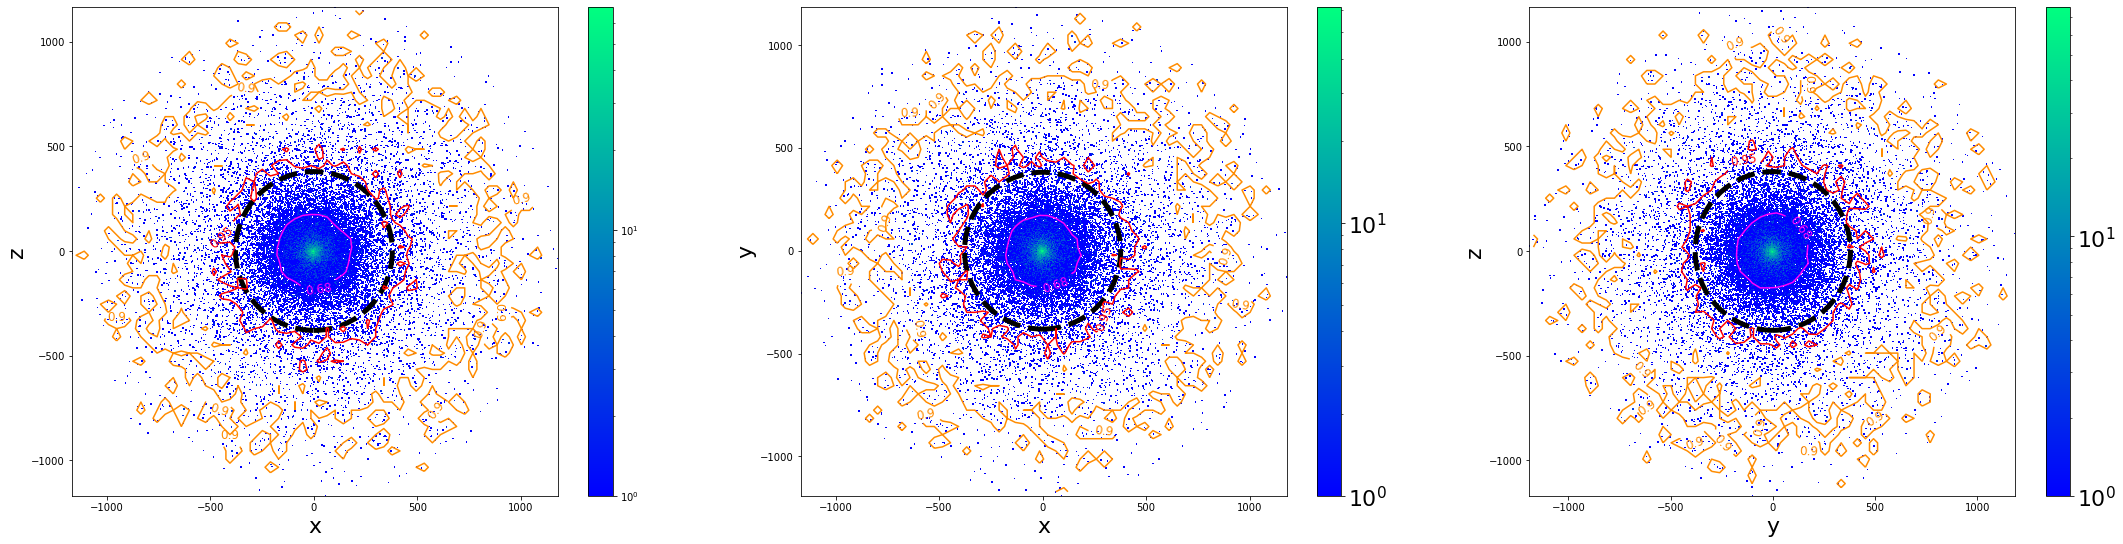

In [8]:
# Rotated MW halo

# MW halo Density 
fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(37, 9))

# plot the particle density for MW , 2D histogram

###################### x, z ###########################################
ax_1 = ax1.hist2d(x, z, bins=1000, norm=LogNorm(), cmap= 'winter')

fig.colorbar(ax_1[3], ax=ax1)

contour, sigma = density_contour(x, z, 60,60,ax=ax1, colors=['darkorange', 'red', 'fuchsia'])

# Add axis labels
ax1.set_xlabel('x', fontsize=22)
ax1.set_ylabel('z', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# creating ellipse curve
a, b = ellipse(x, z, ax1, 2) # getting semimajor and minor axes
print(a, b)
    
ellipses = Ellipse((0, 0),
    width=a,
    height=b,
    edgecolor='k', fc='None', lw=5, linestyle='--')

ax1.add_patch(ellipses)
#set axis limits
#ax1.set_xlim(-5000, 5000)
#ax1.set_ylim(-5000, 5000)

####################### x, y ##########################################
ax_2 = ax2.hist2d(x, y, bins=1000, norm=LogNorm(), cmap= 'winter')

fig.colorbar(ax_2[3], ax=ax2)

contour, sigma = density_contour(x, y, 60,60,ax=ax2, colors=['darkorange', 'red', 'fuchsia'])


# Add axis labels
ax2.set_xlabel('x', fontsize=22)
ax2.set_ylabel('y', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


a, b = ellipse(x, y, ax2, 2)# getting semimajor and minor axes
print(a, b)
    
ellipses = Ellipse((0, 0),
    width=a,
    height=b,
    edgecolor='k', fc='None', lw=5, linestyle='--')

ax2.add_patch(ellipses)

#set axis limits
#ax2.set_xlim(-5000, 5000)
#ax2.set_ylim(-5000, 5000)


####################### y, z ##########################################
ax_3 = ax3.hist2d(y, z, bins=1000, norm=LogNorm(), cmap= 'winter')

fig.colorbar(ax_3[3], ax=ax3)

contour, sigma = density_contour(y, z, 60,60,ax=ax3, colors=['darkorange', 'red', 'fuchsia'])


# Add axis labels
ax3.set_xlabel('y', fontsize=22)
ax3.set_ylabel('z', fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


a, b = ellipse(y, z, ax3, 2)# getting semimajor and minor axes
print(a, b)
    
ellipses = Ellipse((0, 0),
    width=a,
    height=b,
    edgecolor='k', fc='None', lw=5, linestyle='--')

ax3.add_patch(ellipses)
#set axis limits
#ax3.set_xlim(-5000, 5000)
#ax3.set_ylim(-5000, 5000)


# Save to a file
#fig.savefig('plots/MW_M31_000_3subplots_Density.png')

# snapshot 700

In [9]:
# Create a COM of object for MW at snapshot 700 Disk Using Code from Assignment 4
COMD_MW_700 = CenterOfMass("MW_700.txt",1)
COMD_disk_MW_700 = CenterOfMass("MW_700.txt",2)

# Compute COM of MW using halo particles
COMP_MW_700 = COMD_MW_700.COM_P(0.1)
COMV_MW_700 = COMD_MW_700.COM_V(COMP_MW_700[0],COMP_MW_700[1],COMP_MW_700[2])
# Compute COM of MW using disk particles

# Create a COM of object for M31 Halo and Disk Using Code from Assignment 4
COMD_M31_700 = CenterOfMass("M31_700.txt",1)

# Compute COM of M31 using halo particles
COMP_M31_700 = COMD_M31_700.COM_P(0.1)
COMV_M31_700 = COMD_M31_700.COM_V(COMP_M31_700[0],COMP_M31_700[1],COMP_M31_700[2])


In [10]:
# Determine positions of disk particles relative to COM 
xH_MW_700 = COMD_MW_700.x - COMP_MW_700[0].value 
yH_MW_700 = COMD_MW_700.y - COMP_MW_700[1].value 
zH_MW_700 = COMD_MW_700.z - COMP_MW_700[2].value 

# total magnitude
rtot = np.sqrt(xH_MW_700**2 + yH_MW_700**2 + zH_MW_700**2)

# Determine velocities of disk particles relative to COM motion
vxH_MW_700 = COMD_MW_700.vx - COMV_MW_700[0].value 
vyH_MW_700 = COMD_MW_700.vy - COMV_MW_700[1].value 
vzH_MW_700 = COMD_MW_700.vz - COMV_MW_700[2].value 

# total velocity 
vtotMW = np.sqrt(vxH_MW_700**2 + vyH_MW_700**2 + vzH_MW_700**2)

# Vectors for r and v 
rH_MW_700 = np.array([xH_MW_700,yH_MW_700,zH_MW_700]).T # transposed 
vH_MW_700 = np.array([vxH_MW_700,vyH_MW_700,vzH_MW_700]).T

In [11]:
# Determine positions of disk particles relative to COM 
xH_M31_700 = COMD_M31_700.x - COMP_M31_700[0].value 
yH_M31_700 = COMD_M31_700.y - COMP_M31_700[1].value 
zH_M31_700 = COMD_M31_700.z - COMP_M31_700[2].value 

# total magnitude
rtot = np.sqrt(xH_M31_700**2 + yH_M31_700**2 + zH_M31_700**2)

# Determine velocities of disk particles relative to COM motion
vxH_M31_700 = COMD_M31_700.vx - COMV_M31_700[0].value 
vyH_M31_700 = COMD_M31_700.vy - COMV_M31_700[1].value 
vzH_M31_700 = COMD_M31_700.vz - COMV_M31_700[2].value 

# total velocity 
vtot31 = np.sqrt(vxH_M31_700**2 + vyH_M31_700**2 + vzH_M31_700**2)

# Vectors for r and v 
rH_M31_700 = np.array([xH_M31_700,yH_M31_700,zH_M31_700]).T # transposed 
vH_M31_700 = np.array([vxH_M31_700,vyH_M31_700,vzH_M31_700]).T

In [12]:
print(COMP_MW_700[0].value, COMP_MW_700[1].value, COMP_MW_700[2].value) # x,y,z values of MW's COM

print(COMP_M31_700[0].value, COMP_M31_700[1].value, COMP_M31_700[2].value) # x,y,z values of M31's COM

147.09 53.8 110.34
145.96 53.6 109.19


In [13]:
# compute the rotated velocity vectors
rnH_MW_700, vnH_MW_700 = RotateFrame(rH_MW_700,vH_MW_700)

rnH_M31_700, vnH_M31_700 = RotateFrame(rH_M31_700,vH_M31_700)

x_700 = rnH_MW_700[:,0]+rnH_M31_700[:,0]
y_700 = rnH_MW_700[:,1]+rnH_M31_700[:,1]
z_700 = rnH_MW_700[:,2]+rnH_M31_700[:,2]

r_mag_tot_700 = np.sqrt(x_700**2 + y_700**2 + z_700**2)
# using points that are closer within 2 standard deviation of the median
print(np.median(r_mag_tot_700), np.std(r_mag_tot_700))
index_closer_700 = np.where(r_mag_tot_700< (np.median(r_mag_tot_700)+ np.std(r_mag_tot_700)))

print(len(r_mag_tot_700))
print(len(index_closer_700[0]))

x_700 = x_700[index_closer_700]
y_700 = y_700[index_closer_700]
z_700 = z_700[index_closer_700]


585.4781814282475 1328.2188507451765
25000
22654


In [14]:
# only MW
x_MW_700 = rnH_MW_700[:,0]
y_MW_700 = rnH_MW_700[:,1]
z_MW_700 = rnH_MW_700[:,2]

r_mag_tot_MW_700 = np.sqrt(x_MW_700**2 + y_MW_700**2 + z_MW_700**2)
# using points that are closer within 2 standard deviation of the median
print(np.median(r_mag_tot_MW_700), np.std(r_mag_tot_MW_700))
index_closer_MW_700 = np.where(r_mag_tot_MW_700< (np.median(r_mag_tot_MW_700)+ np.std(r_mag_tot_MW_700)))

print(len(r_mag_tot_MW_700))
print(len(index_closer_MW_700[0]))

x_MW_700 = x_MW_700[index_closer_MW_700]
y_MW_700 = y_MW_700[index_closer_MW_700]
z_MW_700 = z_MW_700[index_closer_MW_700]

257.73984181746914 1031.432268214443
25000
23072


0.00022071157425103887
1678.6083381170722 1560.67709477223
0.0002207115736155945
1650.5309462537223 1819.738690734026
0.00022071157326170542
1783.5791899772685 1574.338823793482


(-1700.0, 1700.0)

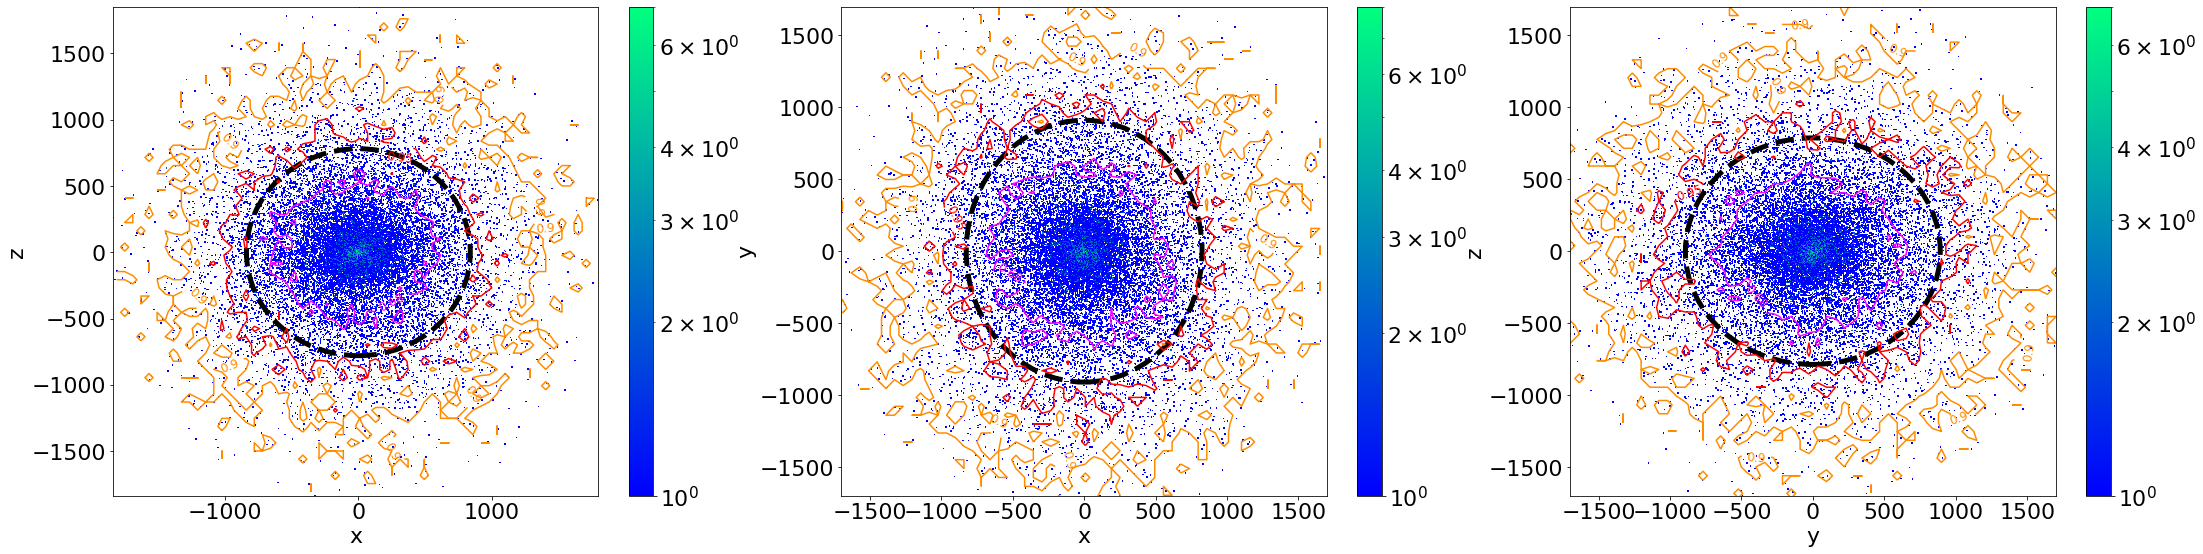

In [15]:
# Rotated MW halo- EDGE ON

# MW halo Density 
fig, (ax1, ax2, ax3)= plt.subplots(1, 3, figsize=(37, 9))

# plot the particle density for MW , 2D histogram
############################## x, z ################################################
ax_1 = ax1.hist2d(x_700, z_700, bins=1000, norm=LogNorm(), cmap= 'winter')

fig.colorbar(ax_1[3], ax=ax1)

contour, sigma = density_contour(x_700, z_700, 60,60,ax=ax1, colors=['darkorange', 'red', 'fuchsia'])
print(sigma)
# Add axis labels
ax1.set_xlabel('x', fontsize=22)
ax1.set_ylabel('z', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


a, b = ellipse(x_700, z_700, ax1, 2)# getting semimajor and minor axes
print(a, b)
    
ellipses = Ellipse((0, 0),
    width=a,
    height=b,
    edgecolor='k', fc='None', lw=5, linestyle='--')

ax1.add_patch(ellipses)

#set axis limits
#ax1.set_xlim(-1700, 1700)
#ax1.set_ylim(-1700, 1700)

############################## x, y ################################################
ax_2 = ax2.hist2d(x_700, y_700, bins=1000, norm=LogNorm(), cmap= 'winter')

fig.colorbar(ax_2[3], ax=ax2)

contour, sigma = density_contour(x_700, y_700, 60,60,ax=ax2, colors=['darkorange','red', 'fuchsia'])
print(sigma)
# Add axis labels
ax2.set_xlabel('x', fontsize=22)
ax2.set_ylabel('y', fontsize=22)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

a, b = ellipse(x_700, y_700, ax2, 2)
print(a, b)
    
ellipses = Ellipse((0, 0),
    width=a,
    height=b,
    edgecolor='k', fc='None', lw=5, linestyle='--')

ax2.add_patch(ellipses)


#set axis limits
ax2.set_xlim(-1700, 1700)
ax2.set_ylim(-1700, 1700)

############################## y, z ################################################
ax_3 = ax3.hist2d(y_700, z_700, bins=1000, norm=LogNorm(), cmap= 'winter')

fig.colorbar(ax_3[3], ax=ax3)

contour, sigma = density_contour(y_700, z_700, 60,60,ax=ax3, colors=['darkorange', 'red', 'fuchsia'])
print(sigma)
# Add axis labels
ax3.set_xlabel('y', fontsize=22)
ax3.set_ylabel('z', fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


a, b = ellipse(y_700, z_700, ax3, 2)# getting semimajor and minor axes
print(a, b)
    
ellipses = Ellipse((0, 0),
    width=a,
    height=b,
    edgecolor='k', fc='None', lw=5, linestyle='--')

ax3.add_patch(ellipses)

#set axis limits
ax3.set_xlim(-1700, 1700)
ax3.set_ylim(-1700, 1700)


# Save to a file
#plt.savefig('plots/MW_M31_700_3subplots_Density.png')

This figure shows the iso-density curves of each plane of the milkdromeda galaxy halo remnant 10Gyrs from today.
We see there is a preferred orientation of an ellipse in the yz where the remnant is wider along the y-axis, and xy planes we see the contour is longer along the y plane at first glance one could assume this means the remannt shows prolate features with one axis longer than the other two however upon closer inspection of their axis ratio values, they indicate there is triaxial formations evolving after the merger.

# second plot: axis ratio versus time

axis ratio b/a


using the ObitCOM function from previous homework we add the ellipse function to loop over
the full 10 Gyrs.

In [22]:
def OrbitCOM(galaxy, start, end, snap):
    """function that loops over all the desired snapshots to compute the COM pos and vel as a function of time.
    inputs:
        galaxy: 'string'
            the name of the galaxy, e.g. “MW”
        start: 'integer'
            the number of the first snapshot to be read in.
        end: 'integer'
            the number of the last snapshot to be read in.
        snap: 'integer'
            an integer indicating the intervals over which you will return the COM.
          
    outputs: 
        a file of the COM and velocity of a galaxy at each snapshot
    """
    
    # compose the filename for output
    fileout = 'AR_evolution_'+galaxy+'.txt'
    
    #  set tolerance and VolDec for calculating COM_P in CenterOfMass
    # for M33 that is stripped more, use different values for VolDec
    delta = 0.1 
    volDec = 2.
    if galaxy == 'M33':
        volDec=4
    
    # generate the snapshot id sequence 
    # it is always a good idea to also check if the input is eligible (not required)
    snap_ids = np.arange(start, end, snap)
    if len(snap_ids)==0:
        os.exit()
    
    # initialize the array for orbital info: t, xy, xz, yz,of COM
    orbit = np.zeros([len(snap_ids), 4])
    
    
    # a for loop 
    for i, snap_id in enumerate(snap_ids):  # loop over files
        
        # compose the data filename (be careful about the folder)
        
        # add a string of the filename to the value "000"
        ilbl = '000'+str(snap_id)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        filename = "%s_"%(galaxy)+'VLowRes/'+"%s_"%(galaxy)+ilbl+'.txt'
     
        # read data in the given file using Read
        time, total, data = Read(filename)   
        
        # Initialize an instance of CenterOfMass class, using disk particles
        
        COM = CenterOfMass(filename, 1) #halo particles
        
        # Store the COM pos and vel. Remember that now COM_P requires volDec
        COM_p = COM.COM_P(0.1)
        COM_v = COM.COM_V(COM_p[0], COM_p[1], COM_p[2])

        
        # finding relative positions to COM
        xH = COM.x - COM_p[0].value 
        yH = COM.y - COM_p[1].value 
        zH = COM.z - COM_p[2].value 
        

        # total magnitude
        rtot = np.sqrt(xH**2 + yH**2 + zH**2)

        # Determine velocities of disk particles relative to COM motion
        vxH = COM.vx - COM_v[0].value 
        vyH = COM.vy - COM_v[1].value 
        vzH= COM.vz - COM_v[2].value 

        # total velocity 
        vtot = np.sqrt(vxH**2 + vyH**2 + vzH**2)

        # Vectors for r and v 
        rH = np.array([xH,yH,zH]).T # transposed 
        vH = np.array([vxH,vyH,vzH]).T
        
        # rotating reference frame to be aligned with the angular momentum arm
        rnH, vnH = RotateFrame(rH,vH)
        
        x = rnH[:,0]
        y = rnH[:,1]
        z = rnH[:,2]

        r_mag_tot = np.sqrt(x**2 + y**2 + z**2)
        # using points that are closer within 2 standard deviation of the median
        index_closer = np.where(r_mag_tot< (np.median(r_mag_tot)+ np.std(r_mag_tot)))

        x = x[index_closer]
        y = y[index_closer]
        z = z[index_closer]
        
        
        # finding the axis ratio at 2-sigma for the xy plane
        contour, xy_sigma = density_contour(x, y, 60,60,ax=ax2, colors=['darkorange', 'red', 'fuchsia'])
        xy_a, xy_b = ellipse(x, y, ax2, 2)
        xy_AR = xy_b/xy_a
        
        # finding the axis ratio at 2-sigma for the xz plane
        contour, xz_sigma = density_contour(x, z, 60,60,ax=ax2, colors=['darkorange', 'red', 'fuchsia'])
        xz_a, xz_b = ellipse(x, z, ax2, 2)
        xz_AR = xz_b/xz_a
        
        # finding the axis ratio at 2-sigma for the yz plane
        contour, yz_sigma = density_contour(y, z, 60,60,ax=ax2, colors=['darkorange', 'red', 'fuchsia'])
        yz_a, yz_b = ellipse(y, z, ax2, 2)
        yz_AR = yz_b/yz_a
        
        AR = np.array([xy_AR, xz_AR, yz_AR]) # xy, xz, yz planes
    
        # store the time, and AR in ith element of the orbit array
        orbit[i] = COM.time.value/1000, *tuple(AR),
        # note that you can store 
        # a[i] = var1, *tuple(array1)

        
        # print snap_id to see the progress
        print(snap_id)
        
    # write the data to a file
    # we do this because we don't want to have to repeat this process 
    # this code should only have to be called once per galaxy.
    print(fileout)
    np.savetxt(fileout, orbit, fmt = "%11.3f"*4, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'xy', 'xz', 'yz'))

In [23]:
OrbitCOM('MW', 0, 700, 20) # finding axis ratio every 285 years (snap*10/.7) Myrs 

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
AR_evolution_MW.txt


In [24]:
MW_data = np.genfromtxt('AR_evolution_MW.txt')

#getting the columns for the MW
MW_t = MW_data[:,0]
MW_AR_xy = MW_data[:,1]
MW_AR_xz = MW_data[:,2]
MW_AR_yz = MW_data[:,3]


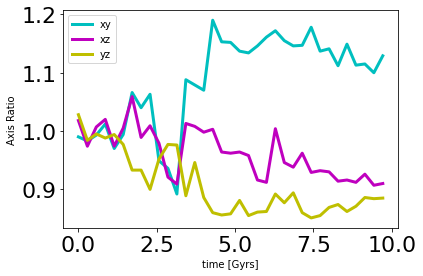

In [25]:
# plotting the axis ratios per time for each plane

plt.plot(MW_t, MW_AR_xy,color='c', linewidth = 3, label='xy')
plt.plot(MW_t, MW_AR_xz,color='m', linewidth=3, label='xz')
plt.plot(MW_t, MW_AR_yz,color='y', linewidth=3, label='yz')
plt.ylabel('Axis Ratio')
plt.xlabel('time [Gyrs]')

plt.legend()
#plt.savefig('plots/AR_plot.png')